In [119]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
import os
from langchain_ollama.llms import OllamaLLM
import unittest
import importlib.util
from IPython.display import Image
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


from langgraph.graph import MessagesState
import re
import pytest
import subprocess

In [120]:
class State(TypedDict):
    topic: str
    output: str
    review_comments: str
    decision:str
    plan: str
    research: str

In [121]:
llm = OllamaLLM(model="deepseek-r1:1.5b")

### Nodes

In [122]:
# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["accept", "reject", "review"] = Field(
        None, description="The next step in the routing process"
    )


In [123]:
from rich.console import Console
from rich.markdown import Markdown

console = Console()

def print_llm_response(response):
    """Pretty print LLM response as Markdown."""
    console.print(Markdown(response))  # Rich formats Markdown-like LLM output

In [124]:
def initial_plan(state:State):
    """Make a initial plan for the user's topic"""
    res = llm.invoke(f"Make a draft plan on how to execute {state["topic"]}.")
    
    print("### Made a plan ####")
    print_llm_response(process_deepseek_res(res))
    print("####################")

    return {"plan": process_deepseek_res(res)}

def do_research(state:State):
    """Do a research on the plan created"""
    res = llm.invoke(f"Do a research on the plan created {state['plan']}.")

    print("### Finished my research ####")
    print_llm_response(process_deepseek_res(res))
    print("####################")

    return {"research": process_deepseek_res(res)}

def write(state:State):
    """Write summary for the research by using the plan"""
    res = llm.invoke(f""" my plan: {state['plan']}
                          my research: {state['research']}
                          Execute my plan on my research to **write a good summary**.""")

    print("### Here is my writeup ####")
    print_llm_response(process_deepseek_res(res))
    print("####################")

    return {"output": process_deepseek_res(res)}


# this will be my router
def editor(state: State):
    ## get user input
    user_input=input("Please choose one of the option and press enter: A - Approve, R - Reject, C - Comments")
    return {'decision': user_input}

def reject(state:State):
    """Editor rejected the writeup"""
    return {"output": "editor rejected the write up"}

def accept(state:State):
    """Editor accepted the writeup"""
    return {"output": "editor accepted the write up"}

def review(state:State):
    """Editor make comments on the write up for enhancements"""
    user_input = input(f"what would you like to add more?")
    return {'review_comments': user_input}

def research_revise(state:State):
    """ Add review comments by Editor to the given topic and re-write the story"""

    print("### Researching again with user comments ####")
    print_llm_response(process_deepseek_res(state['review_comments']))
    print("####################")

    prompt = f"""Here is an existing summary:
                {state['output']} for the topic {state['topic']}
                Here are the user's comments and feedback:
                {state['review_comments']}

                Using the user's comments, re-write the summary to better align with their feedback. 
                Maintain clarity, conciseness, and coherence while incorporating the requested changes."""
    
    return {'output':prompt}

# Conditional edge function to route to the appropriate node
def editor_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "A" or state["decision"] == "a" :
        return "accepted"
    elif state["decision"] == "R" or state["decision"] == "r":
        return "rejected"
    elif state["decision"] == "C" or state["decision"] == "c":
        return "review_comments"

def process_deepseek_res(msg):
    return re.sub(r'<think>.*?</think>', '', msg, flags=re.DOTALL).strip()

### Workflow

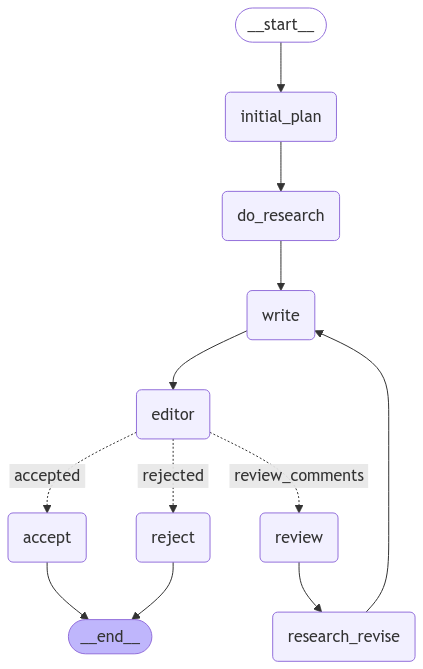

In [125]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("initial_plan", initial_plan)
workflow.add_node("do_research", do_research)
workflow.add_node("write", write)
workflow.add_node("editor", editor)
workflow.add_node("reject", reject)
workflow.add_node("accept", accept)
workflow.add_node("review", review)
workflow.add_node("research_revise", research_revise)

# Add Edges
workflow.add_edge(START, "initial_plan")
workflow.add_edge("initial_plan", "do_research")
workflow.add_edge("do_research", "write")
workflow.add_edge("write", "editor")
workflow.add_conditional_edges(
    "editor",
    editor_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "rejected": "reject",
        "accepted": "accept",
        "review_comments": "review",
    },
)
workflow.add_edge("reject", END)
workflow.add_edge("accept", END)
workflow.add_edge("review", "research_revise")
workflow.add_edge("research_revise", "write")

# memory = MemorySaver()

# # Compile
# chain = workflow.compile(interrupt_after=["editor"], checkpointer=memory)
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [126]:
# Invoke
state = chain.invoke({"topic": "what is Pythagoras theorm?"})
print(state["output"])

### Made a plan ####


Certainly! Here's an organized and elegant explanation of the Pythagorean theorem:                                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Exploring the Pythagorean Theorem                                                                                  

 1 Introduction to the Theorem                                                                                     
    • The Pythagorean theorem is a fundamental principle in Euclidean geometry that relates the three sides of a   
      right-angled triangle.                                                                                       
    • It states that for any right-angled triangle, the square of the length of the hypotenuse (the side opposite  
      the right angle) is equal to the sum of the squares of the lengths of the other two sides.                   
 2 Visualizing the Theorem                                                                                         
    • Draw a right-angled triangle with vertices labeled A, B, and C.                                              
    • Label the legs as 'a' and 'b', and the hypotenuse as 'c'.                                                    
    • Illustrate the concept by drawing squares on each side; these squares will have areas corresponding to a²,   
      b², and c² respectively.                                                                                     
 3 Understanding the Equation                                                                                      
    • Introduce the equation: ( a^2 + b^2 = c^2 ).                                                                 
    • Explain that this theorem is crucial for understanding relationships in geometry and has applications in     
      various fields like physics and engineering.                                                                 
 4 Historical Context                                                                                              
    • Mention that while known to earlier civilizations (e.g., ancient Mesopotamia, Egypt) with proofs attributed  
      to mathematicians like Thales), the theorem is traditionally named after Pythagoras due to his school's      
      influence.                                                                                                   
    • Highlight that it was later popularized by Euclid in his work "Elements."                                    
 5 Proof Methods                                                                                                   
    • Discuss different methods of proof:                                                                          
       • Euclidean Proof: Utilize right angles and similar triangles, showing how the theorem can be derived       
         through geometric construction.                                                                           
       • Coordinate Geometry: Explain how the distance formula is a direct application of the Pythagorean theorem  
         in calculating distances between points.                                                                  
 6 Applications                                                                                                    
    • Explore real-world applications, such as:                                                                    
       • Construction for ensuring structures are square.                                                          
       • Physics for calculating resultant vectors.                                                                
       • Navigation systems using triangulation.                                                                   
 7 Conclusion                                                                                                      
    • Emphasize the theorem's enduring importance and 

####################
### Finished my research ####


The Pythagorean theorem is a fundamental principle in Euclidean geometry that relates the three sides of a         
right-angled triangle. It states that for any right-angled triangle, the square of the length of the hypotenuse    
(the side opposite the right angle) is equal to the sum of the squares of the lengths of the other two sides. This 
theorem has been extensively studied and applied across various fields, from mathematics to physics and            
engineering.                                                                                                       

                                                Theorem Statement:                                                 

For a right-angled triangle with legs 'a' and 'b', and hypotenuse 'c', the theorem states: [ c^2 = a^2 + b^2 ] This
means that the square of the hypotenuse is equal to the sum of the squares of the other two sides.                 

                                                Historical Context:                                                

 • Historical Background: The theorem was known to earlier civilizations, such as ancient Mesopotamia and Egypt,   
   with proofs attributed to mathematicians like Thales. It is traditionally named after Pythagoras (570–495 BCE), 
   a Greek mathematician who lived in the 6th century BCE.                                                         
 • Influence: The theorem was popularized by Euclid in his work "Elements" around 300 BCE, and later by other      
   scholars.                                                                                                       

                                                  Proof Methods:                                                   

 1 Euclidean Geometry: Utilizes right angles and similar triangles to derive the relationship.                     
 2 Algebraic Manipulation: Often visualized geometrically as rearranging shapes or algebraically through           
   substitution.                                                                                                   
 3 Generalization: Extended to three dimensions (sum of squares equals cube) and vector analysis.                  

                                              Cultural Significance:                                               

 • Historical Use: The ancient Egyptians used it for precise pyramid measurements, indicating its importance in    
   construction.                                                                                                   
 • Cultural Impact: Babylonians and other cultures recognized the theorem before formalizing it by Pythagoras.     

                                                   Applications:                                                   

 • ** Architecture & Engineering:** Ensures right angles and stability in structures, crucial for buildings and    
   slopes.                                                                                                         
 • Physics: Calculates resultant vectors and velocities, aiding in velocity addition.                              
 • Navigation Systems: GPS uses triangulation involving right triangles to determine coordinates accurately.       

                                                Educational Impact:                                                

 • Critical Thinking: Teaches logical reasoning and spatial awareness, fundamental for problem-solving.            
 • Mathematical Connections: Links geometry with trigonometry and calculus, enhancing interdisciplinary            
   understanding.                                                                                                  

                                                    Extensions:                                                    

 • Higher Dimensions: Extends to three dimensions as the sum of squares equals cube.                               
 • Vectors & Calculus: Used in vector addi

####################
### Here is my writeup ####


The Pythagorean theorem is a cornerstone of geometry that states for any right-angled triangle with legs (a) and   
(b), and hypotenuse (c), the sum of the squares of the legs equals the square of the hypotenuse. This can be       
expressed as:                                                                                                      

[ a^2 + b^2 = c^2 ]                                                                                                

This theorem has fundamental implications in various fields, including mathematics, physics, engineering, computer 
graphics, and technology. It is a basic concept that supports spatial reasoning and mathematical relationships,    
forming a building block for more complex topics like coordinate geometry and trigonometry. The theorem's enduring 
relevance today stems from its foundational nature in understanding space itself.                                  

                                                   Final Answer                                                    

The Pythagorean theorem states that for a right-angled triangle with legs (a) and (b), and hypotenuse (c), the sum 
of the squares of the legs equals the square of the hypotenuse: (\boxed{a^2 + b^2 = c^2}).

####################
### Researching again with user comments ####


add few mathematical examples to prove the theorm

####################
### Here is my writeup ####


Certainly! Here's a well-organized summary of the Pythagorean theorem, covering its statement, history, proof      
methods, applications, educational impact, cultural significance, extensions, and famous problems.                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Pythagorean Theorem Summary                                                                                        

  1 Statement of the Theorem                                                                                       
     • In a right-angled triangle, the square of the hypotenuse (the side opposite the right angle) is equal to the
       sum of the squares of the other two sides.                                                                  
     • Mathematically, if the legs are ( a ) and ( b ), and the hypotenuse is ( c ), then: [ c^2 = a^2 + b^2 ]     
  2 History                                                                                                        
     • The theorem is believed to have been known to ancient civilizations such as Mesopotamia and Egypt.          
     • Thales, one of the Pythagorean school's members, is often credited with its discovery through his work on   
       geometry.                                                                                                   
     • Pythagoras popularized it through Euclid's "Elements," which is a foundational text in mathematics.         
  3 Proof Methods                                                                                                  
     • Similar Triangles: Using proportions to demonstrate ( c^2 = a^2 + b^2 ).                                    
     • Algebraic Manipulation: Expanding equations and simplifying.                                                
     • Geometric demonstrations: Using visual aids like squares on each side of the triangle.                      
  4 Applications                                                                                                   
     • Architecture and Engineering: Ensuring right angles and stability in structures.                            
     • Physics: Vector addition, velocity components, and calculating forces.                                      
     • Navigation: GPS uses vector calculations for precise positioning.                                           
     • Computer Graphics: 3D rendering requires accurate geometric computations.                                   
  5 Educational Impact                                                                                             
     • Develops critical thinking and spatial awareness.                                                           
     • Makes abstract mathematical concepts relatable through real-world applications.                             
  6 Cultural Significance                                                                                          
     • Recognized by ancient cultures before formalizing it by Pythagoras.                                         
     • A testament to human ingenuity, showing how continuous exploration in mathematics is possible.              
  7 Extensions                                                                                                     
     • Higher Dimensions: The theorem extends to three dimensions (e.g., vectors in 3D space).                     
     • Vector Calculus: Understanding vector operations and their applications in various fields.                  
  8 Famous Problems and Puzzles                                                                                    
     • Ancient Greek mathematicians used the theorem to solve quadratic equations, leading to significant          
       mathematical advancements.                                                                                  
     • Problems involving right triangles often appear

####################
editor accepted the write up
